<a href="https://colab.research.google.com/github/mgoncerz/ml_zaliczenie_projekt/blob/master/projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The idea is to compare the accuracy of various ML methods in reckognizing handwritten letters from alphabets of different complexity.

Loading libraries:

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties

import pandas as pd

import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, adam
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.utils.vis_utils import plot_model
from IPython.display import Image 

from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import metrics

Hiragana:

1. Loading data (https://www.kaggle.com/anokas/kuzushiji):

In [0]:
images_train = np.load('kmnist-train-imgs.npz')['arr_0']
images_test = np.load('kmnist-test-imgs.npz')['arr_0']

data_length = images_train[0].shape[0] * images_train[0].shape[1]

x_train = images_train.reshape(len(images_train), data_length).astype('float32')
x_test = images_test.reshape(len(images_test), data_length).astype('float32')

labels_train = np.load('kmnist-train-labels.npz')['arr_0']
labels_test = np.load('kmnist-test-labels.npz')['arr_0']

y_train = keras.utils.to_categorical(labels_train, 10)
y_test = keras.utils.to_categorical(labels_test, 10)

labels_map = pd.read_csv("kmnist_classmap.csv", encoding="utf-8")

2. Input data analysis:

   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を


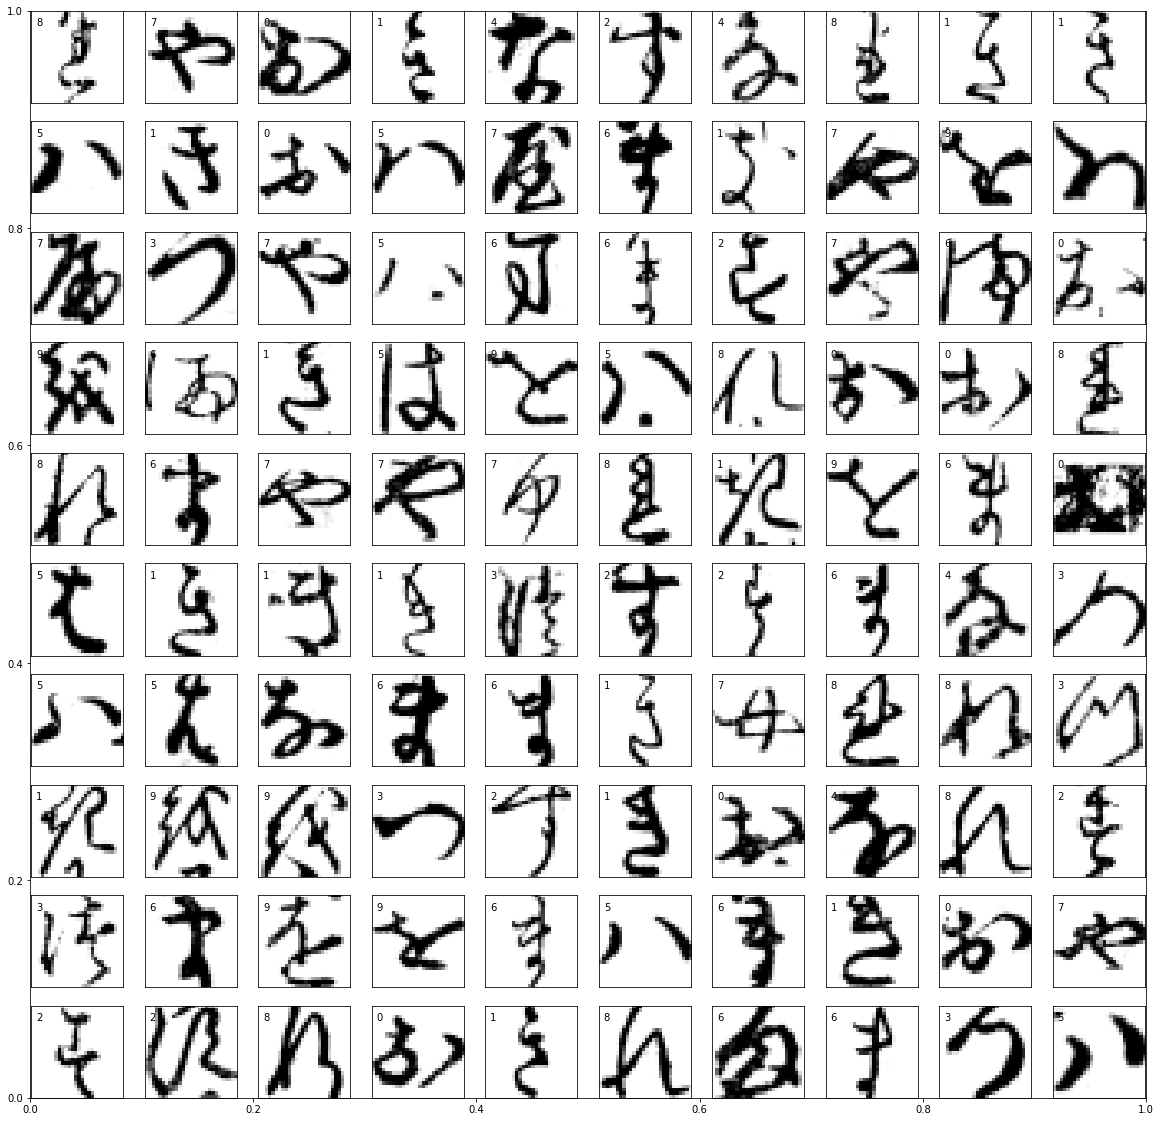

In [28]:
print(labels_map)

fig, axes = plt.subplots(figsize=(20,20))

for i in range(100):
  ax = fig.add_subplot(10,10,i+1,xticks=[], yticks=[])
  ax.imshow(images_train[i], cmap=plt.cm.binary, interpolation='nearest')
  ax.text(1, 4, str(labels_train[i]))

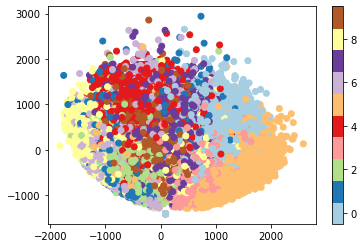

In [29]:
projection = PCA(n_components=2).fit_transform(x_train)
plt.scatter(projection[:, 0], projection[:, 1], c=labels_train.astype(int), cmap=plt.get_cmap('Paired', 10), vmin=-0.5, vmax=9.5)
plt.colorbar()

3. Simple approach (naive Bayes and Fisher):



Bayes:
Score:  0.4622
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1000
           1       0.40      0.64      0.49      1000
           2       0.26      0.61      0.37      1000
           3       0.68      0.53      0.59      1000
           4       0.40      0.29      0.34      1000
           5       0.52      0.24      0.33      1000
           6       0.67      0.25      0.37      1000
           7       0.61      0.42      0.50      1000
           8       0.42      0.60      0.49      1000
           9       0.47      0.36      0.41      1000

    accuracy                           0.46     10000
   macro avg       0.52      0.46      0.46     10000
weighted avg       0.52      0.46      0.46     10000



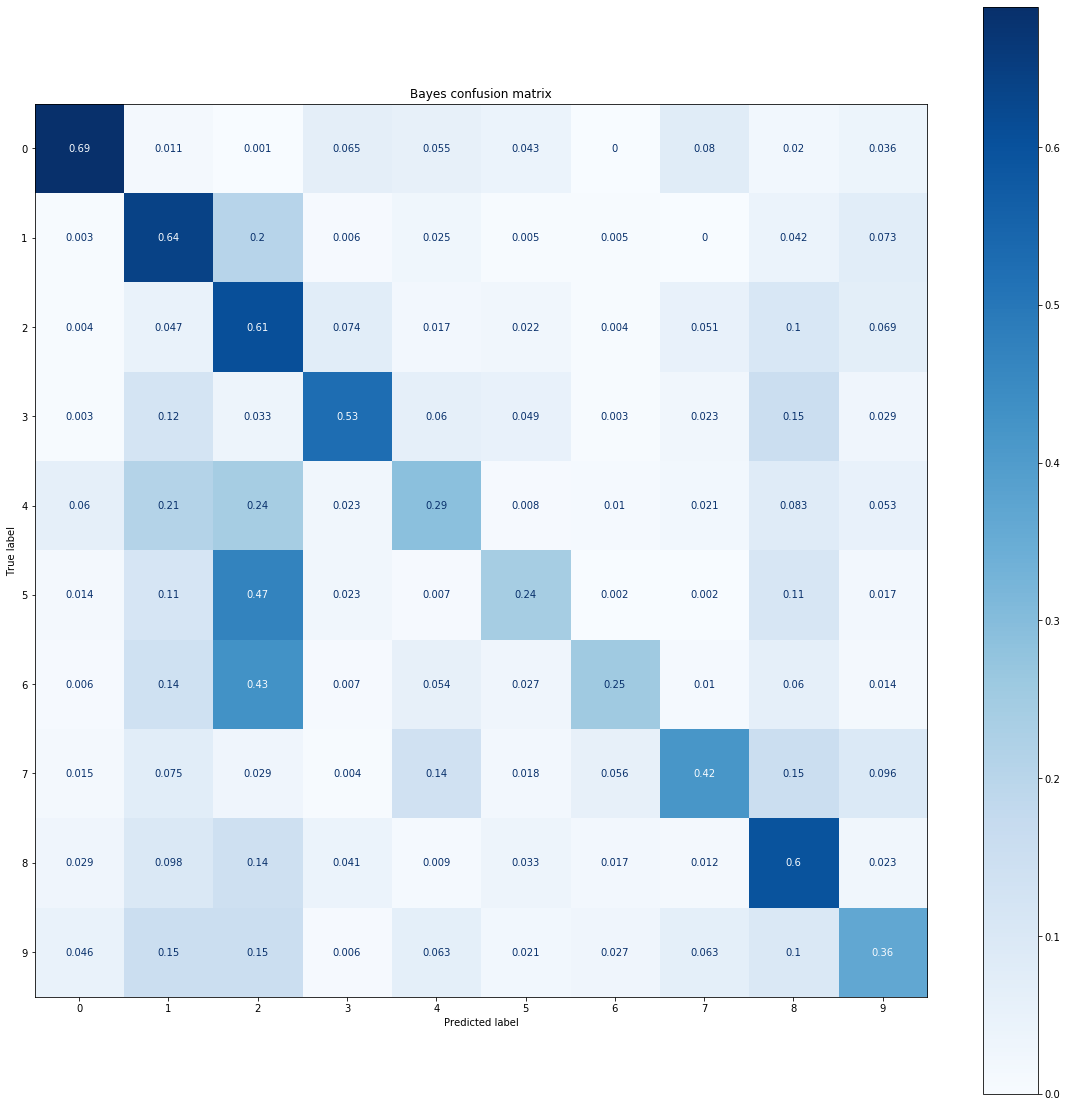

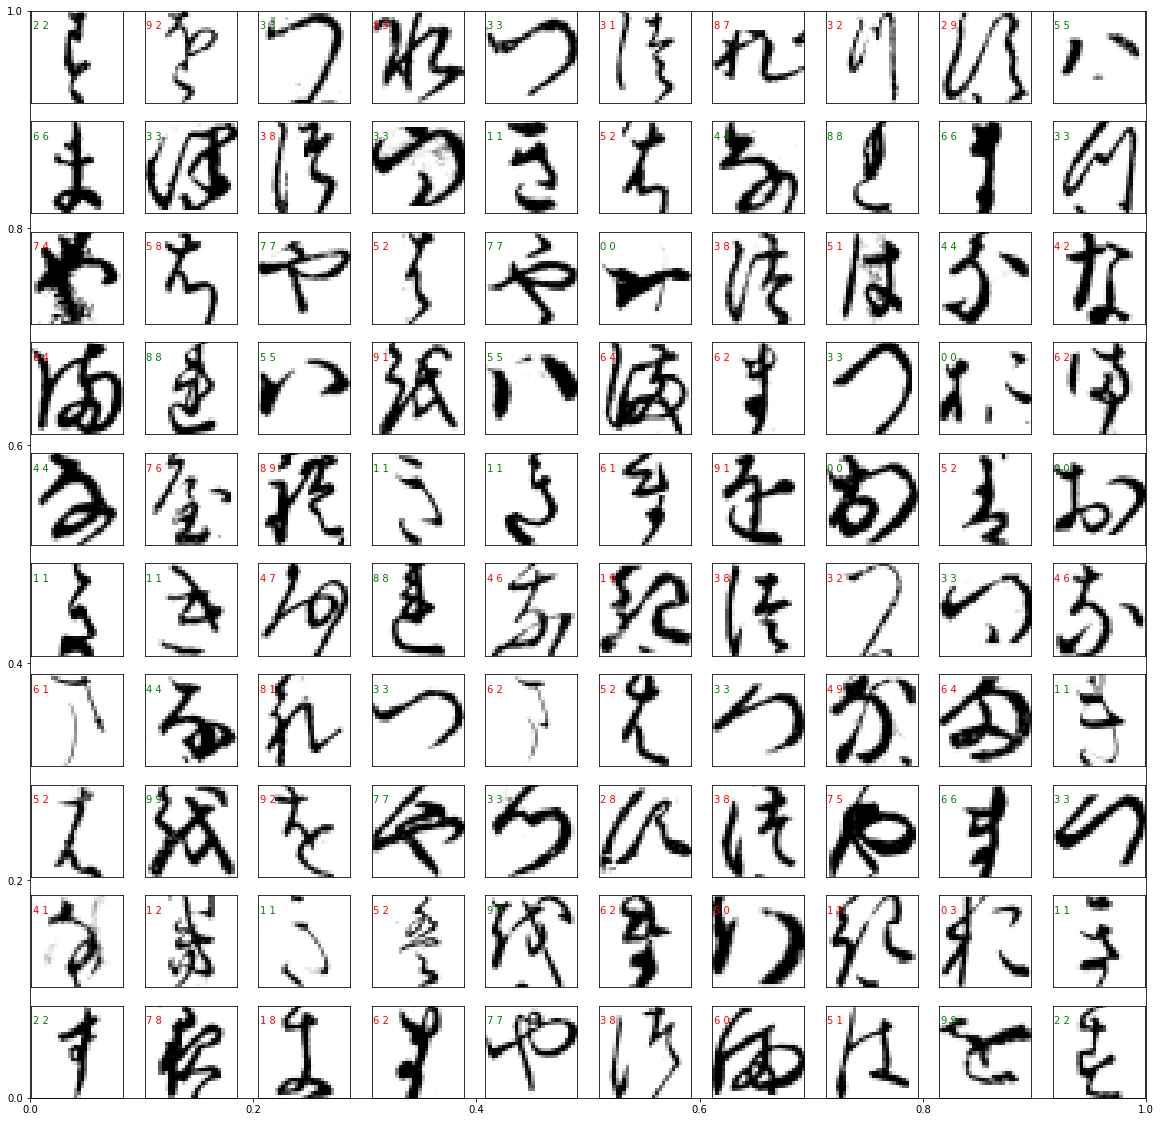

In [54]:
print("Bayes:")
nb_model = GaussianNB()
nb_model.fit(x_train, labels_train) #note this takes labels as single numbers per input element, not transformed to dij form
nb_prediction = nb_model.predict(x_test)
print("Score: ", nb_model.score(x_test, labels_test))

fig, axes = plt.subplots(figsize=(20,20))

print(metrics.classification_report(labels_test, nb_prediction))

nb_cfm = metrics.plot_confusion_matrix(nb_model, x_test, labels_test, cmap=plt.cm.Blues, normalize = "true", ax = axes)
nb_cfm.ax_.set_title("Bayes confusion matrix")


fig, axes = plt.subplots(figsize=(20,20))

for i in range(100):
  ax = fig.add_subplot(10,10,i+1,xticks=[], yticks=[])
  ax.imshow(images_test[i], cmap=plt.cm.binary, interpolation='nearest')

  if(nb_prediction[i] == labels_test[i]):
    ax.text(0, 5, str(labels_test[i])+" "+str(nb_prediction[i]), color='green')
  else:
    ax.text(0, 5, str(labels_test[i])+" "+str(nb_prediction[i]), color='red')   



Fisher:
Score:  0.4622
              precision    recall  f1-score   support

           0       0.86      0.61      0.72      1000
           1       0.54      0.62      0.58      1000
           2       0.38      0.65      0.48      1000
           3       0.79      0.61      0.69      1000
           4       0.58      0.60      0.59      1000
           5       0.65      0.45      0.53      1000
           6       0.60      0.69      0.64      1000
           7       0.75      0.43      0.55      1000
           8       0.48      0.67      0.56      1000
           9       0.65      0.52      0.58      1000

    accuracy                           0.59     10000
   macro avg       0.63      0.59      0.59     10000
weighted avg       0.63      0.59      0.59     10000



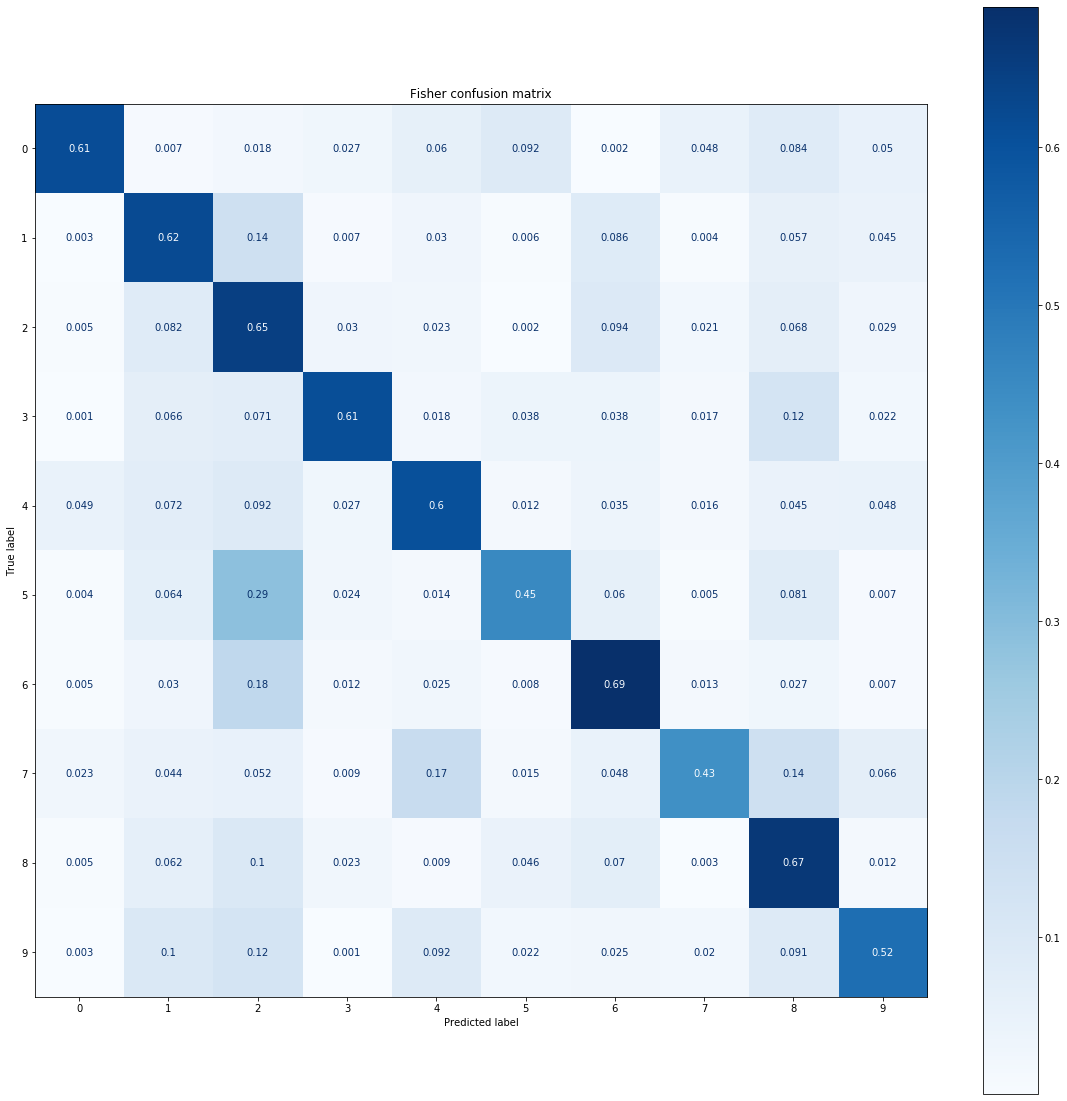

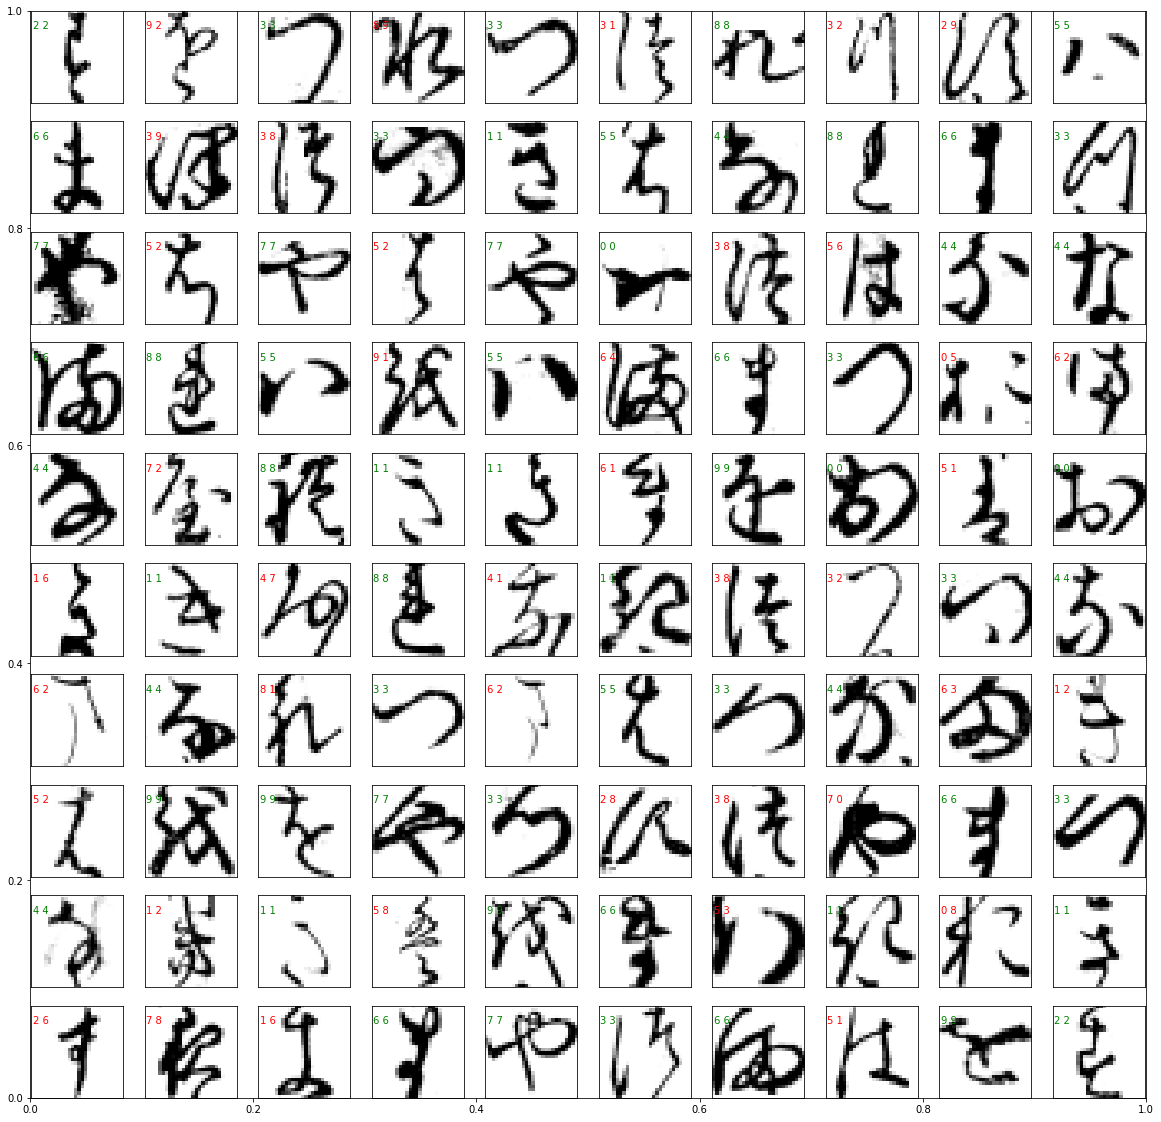

In [55]:
print("Fisher:")
f_model = LinearDiscriminantAnalysis()
f_model.fit(x_train, labels_train) #note this takes labels as single numbers per input element, not transformed to dij form
f_prediction = f_model.predict(x_test)

print("Score: ", nb_model.score(x_test, labels_test))

fig, axes = plt.subplots(figsize=(20,20))

print(metrics.classification_report(labels_test, f_prediction))

nb_cfm = metrics.plot_confusion_matrix(f_model, x_test, labels_test, cmap=plt.cm.Blues, normalize = "true", ax = axes)
nb_cfm.ax_.set_title("Fisher confusion matrix")


fig, axes = plt.subplots(figsize=(20,20))

for i in range(100):
  ax = fig.add_subplot(10,10,i+1,xticks=[], yticks=[])
  ax.imshow(images_test[i], cmap=plt.cm.binary, interpolation='nearest')

  if(f_prediction[i] == labels_test[i]):
    ax.text(0, 5, str(labels_test[i])+" "+str(f_prediction[i]), color='green')
  else:
    ax.text(0, 5, str(labels_test[i])+" "+str(f_prediction[i]), color='red') 